In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random as rd

In [3]:
rd.seed(1)

This is a function to compute the sharpe_ratio

In [4]:
def sharpe_ratio(returns_risky, keys, returns_risk_free):
    mean_risk_free = np.mean(np.mean(returns_risk_free, 0))
    ratio = {}
    for key in keys:
        mean_return_risky = np.mean(returns_risky[key])
        sigma_risky = np.var(returns_risky[key])
        ratio[key] = (mean_return_risky - mean_risk_free)/sigma_risky
    return ratio        

These are the same functions used in the Lasso regression workbook

In [5]:
def calculate_transaction_costs(change_in_positions, cost_per_trade):
    return np.sum(np.abs(change_in_positions)) * cost_per_trade
def ret2price(ret):
    price = np.ones(len(ret))
    for i in range(1, len(ret)):
        price[i] = ret[i]*price[i-1]
    return price
def price2ret(price):
    ret = np.ones(len(price))
    for i in range(1, len(ret)):
        ret[i] = price[i]/price[i-1]
    return ret

Here we import the dataset with the predictions form the neural network classifier for various thresholds

In [6]:
Valori_Predetti = pd.read_excel('Valori_Predetti.xlsx', sheet_name = 'Validation')
keys = Valori_Predetti.columns
Valori_Predetti = Valori_Predetti.drop(0)
result = {key: Valori_Predetti[key].tolist() for key in keys}

Here we import the futures dataset as well as eliminate some of the futures from our portfolio. We removed them during the data exploration phase by considering their correlation and other financial factors in order to get a better tracking that generalizes well during the whole period. The idea is to remove futures in such a way that the Kalman filter uses almost always more or less the same futures so as to not incur in too many transaciton fees. This part was handled automatically by the Lasso penalty in the linear regression

In [7]:
# Read data
data = pd.read_excel('InvestmentReplica2.xlsx', sheet_name='Replica')
dates = data['Date'].values
data.drop(columns=['Date'], inplace=True)

# Target index
data['Target'] = 0.25 * data['HFRXGL'] + 0.5 * data['MXWO'] + 0.25 * data['LEGATRUU']

# Compute returns for all columns
returns = data.pct_change()+1
returns.drop(index=0, inplace=True)

# Features selection
features = returns.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU', 'MXWD','LLL1','Target','TP1','TY1','VG1','DU1', 'NQ1'])
target = 'Target'
X = returns[features].values
y = returns[target].values

Here's the code that implements the Kalman filter in order to predict the portfolio weights to accurately replicate the index.
In the code we set a parameter alpha that handles the exposure we want to keep.
The idea is to use the Neural_Network classifier to predict anomalies in the market, if we find an anomaly (it may be both a market crash or a sudden market upward movement) we decrease our net-exposure in such a way to keep steady returns with as few sudden variations as possible. Our aim is not to outperform the index but to have a less volatile position that avoids big market movements.

In this case we set a value of alpha of 0 just for demonstration purposes

What we are trying to do here is to select the optimal threshold for the classifier, our neural network yields a probability for a particular week to be an anomaly. It's up to us to decide starting from what probability we decide to reduce our exposure. So we consider different classifications for different thresholds, and we pick the one that performs best in the validation set. In our case we choose as performance metric the differences between our realized portfolio price and the index price. This can be visualized as the area between the curve of the two price paths.
Other performance metrics may be chosen, for example some measure of the volatility of the portfolio over the whole period (which we would want to minimize).


0.404


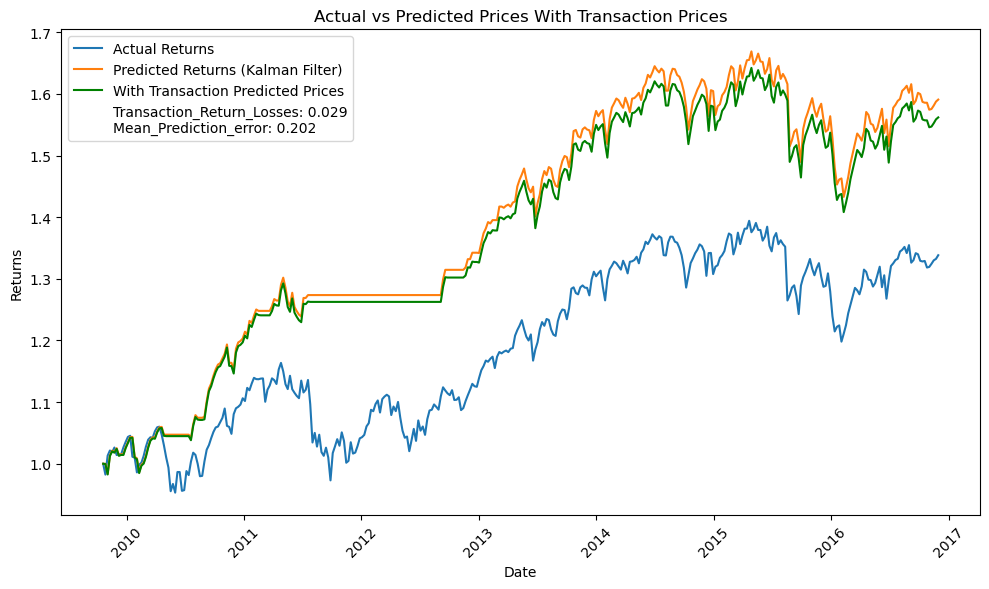

In [8]:
# Initialized vectors
y_test_kalman = []
y_pred_kalman = []
dates_plot_kalman = []

# Define parameters for Kalman filter
num_features = X.shape[1]
num_time_steps = len(y)

A = np.eye(num_features)
B = np.diag(np.diag(np.cov(X.T)))
C = np.eye(num_features)  # Initialization of C(t)
D = np.std(y)

Q = np.cov(X, rowvar=False)
R = D**2

window_size = 104

portfolio_weights=[]
adjusted_portfolio_prices=[]

# Apply rolling window with Kalman filter
for i in range(window_size, len(returns) - 1):
    # Split the data into training and testing sets using rolling window
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+1]  # Test set contains one sample from the next time step
    
    # Initialize state estimate and covariance for the window
    x_estimate = np.zeros(num_features)
    P_estimate = np.eye(num_features)
    
    # Kalman filter loop for training set
    for t in range(window_size):
        # Predict
        x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
        P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q

        # Update
        C = X_train[t].reshape(1, -1)
        K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
        residual = y_train[t] - np.dot(C, x_estimate)
        x_estimate = x_estimate + np.dot(K, residual)
        P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    # Prediction step for the test instance
    C = X_test
    x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
    P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q
    K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
    residual = y_train[-1] - np.dot(C, x_estimate)
    x_estimate = x_estimate + np.dot(K, residual)
    P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    portfolio_weights.append(x_estimate)
    y_test_kalman.append(y[i])
    y_pred_kalman.append(np.dot(C, x_estimate))  # Only extract the prediction for the single test instance
    dates_plot_kalman.append(dates[i])

#Now that we have built our basic portfolio using kalman filter we build different reducing our exposure when we detect
#an anomaly. This is done for different thresholds and the results are stored in a dictionary.
x_estimate_new={}
y_pred_kalman_new = {}
alpha = 0

for key in keys:
    x_estimate_new[key] = portfolio_weights.copy()  
    flat_list = [item[0] for item in y_pred_kalman] 
    y_pred_kalman_new[key] = flat_list

for key in keys:
    anomalie = [i for i, valore in enumerate(result[key]) if valore == 1]
    anomalie = [x - window_size for x in anomalie]
    for i in range(len(y_pred_kalman)):
        if i in anomalie:
            x_estimate_new[key][i] = x_estimate_new[key][i]*alpha
            y_pred_kalman_new[key][i] = y_pred_kalman_new[key][i]*alpha + (1-alpha)
            
#rmse_kalman = np.sqrt(mean_squared_error(y_test_kalman, y_pred_kalman))
#mae_kalman = mean_absolute_error(y_test_kalman, y_pred_kalman)

adjusted_portfolio_prices = {}
for key in keys:
    weight_changes = abs(np.diff(x_estimate_new[key], axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices[key] = [1]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[key][-1] * (y_pred_kalman_new[key][i+1]) - transaction_cost
        adjusted_portfolio_prices[key].append(adjusted_price)

prices_test_kalman = ret2price(np.array(y_test_kalman))

prices_pred_kalman = {}
for key in keys:
    prices_pred_kalman[key] = ret2price(np.array(y_pred_kalman_new[key]))

performance = {}
for key in keys:
    performance[key] = sum(prices_pred_kalman[key]-prices_test_kalman)

best_key = max(performance, key=performance.get)

print(best_key)
    
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates_plot_kalman, prices_test_kalman, label='Actual Returns')
plt.plot(dates_plot_kalman, prices_pred_kalman[best_key], label='Predicted Returns (Kalman Filter)')
plt.plot(dates_plot_kalman , adjusted_portfolio_prices[best_key], label='With Transaction Predicted Prices', color='Green')

Transaction_losses=prices_pred_kalman[0.404][-1]-adjusted_portfolio_prices[0.404][-1]

Mean_Prediction_error=np.mean(np.abs(prices_pred_kalman[0.404]-prices_test_kalman))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])
last_key_pred_kalman = list(prices_pred_kalman.keys())[-1]
last_key_adjusted_portfolio = list(adjusted_portfolio_prices.keys())[-1]

plt.xlabel('Date')
plt.ylabel('Returns')
#plt.title('Actual vs Predicted Returns using Kalman Filter (RMSE={:.4f})'.format(rmse_kalman))
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.tight_layout()
plt.show()

Above is the plot of the graph for the index and our portfolio price during the validation period with the optimal threshold found (in sample). Here we set alpha=0 which means that we basically liquidate our whole position when we detect an anomaly. This is done just for demonstration purposes as it makes it easy to see where the algorithm decides to consider a week as an anomaly (it's just a straight line in the graph since we don't invest anything and we assume a r=1 risk free rate).
Obviously here we see that we clearly outperform the index, since the parameter was optimized in sample to do so. 

We managed to avoid a big market movement from 2011 to 2013 and other significant steep market movement, unfortunately in the end we weren't able to avoid two relevant declines. 

The optimal threshold is 0.404, we will use this to test the performance of the algorithm on our test set.